# Deep Learning pour Classification

Ce notebook regroupe quelques configurations d'algorithmes de Deep Learning pour la classification de données.

In [1]:
import numpy
import time

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from matplotlib import pyplot



Variable                        Possibilités             Nombre de colonne (+1)
Spécialité de médecins	        33 codes de spécialité	        1-33
Sexe de médecin 	            2	                            34-35
Langue de correspondance 	    2	                            36-37
Université de graduation 	    14 universités	                38-51
Plage horaire de facturation	3 (AM, PM, toute la journée)	52-54
Agence de représentation	    845 codes d’agences             55-899
Établissements                  241 établissements	            900-1140
ActeMedical                     2 (Oui et Non)	                1141-1142
Activités médico-admin          2 (Oui et Non)	                1143-1144
Activités d’enseignement	    2 (Oui et Non)	                1145-1146
Entente LE	                    2 (Oui et Non)	                1147-1148
Activité en santé communautaire	2 (Oui et Non)	                1149-1150
Activité en santé comm. CSST	2 (Oui et Non)	                1151-1152
Activité en santé 

## 1. Enregistrement des jeux de données comportant les données avec étiquettes
Ici, le jeu de données comportant uniquement les données avec des étiquettes de classe est téléchargé (dans sa forme initiale). Il est ensuite séparé en jeux d'entraînement et de test en plus d'être normalisé dans toutes les dimensions. Il en va de même pour le jeu de données dont les dimensions ont été réduites suite à l'étape de réduction de dimensionnalité.

In [14]:
labeledData = numpy.load('labeled.npy')
numberOfData = labeledData.shape[0] # 1441
dimensions = labeledData.shape[1] # 1183

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train = minmax_scale(labeledData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test = minmax_scale(labeledData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

reducedData = numpy.load('labeled_reduit_100dim.npy')
numberOfData = reducedData.shape[0]
dimensions = reducedData.shape[1]

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train_reduced = minmax_scale(reducedData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test_reduced = minmax_scale(reducedData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

## 2. Déclaration de fonctions utilitaires (utilisées dans les TP)

In [3]:
def create_balanced_sampler(dataset):
    def make_weights_for_balanced_classes(images, n_classes):                        
        count = [0] * n_classes                                                      
        for item in images:                                                         
            count[int(item[1])] += 1                                                     
        weight_per_class = [0.] * n_classes                                      
        N = float(sum(count))                                                   
        for i in range(n_classes):                                                   
            weight_per_class[i] = N/float(count[i])                                 
        weight = [0] * len(images)                                              
        for idx, val in enumerate(images):                                          
            weight[idx] = weight_per_class[int(val[1])]                                  
        return weight

    n_classes = numpy.unique(dataset.targets)
    weights = make_weights_for_balanced_classes(dataset.data, len(n_classes))                                                         
    weights = torch.DoubleTensor(weights)                 
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 
    return sampler

def compute_accuracy(model, dataloader, device='cpu'):
    training_before = model.training
    model.eval()
    all_predictions = []
    all_targets = []
    
    for i_batch, batch in enumerate(dataloader):
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(images)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    if all_predictions[0].shape[-1] > 1:
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else:
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0
        predictions_numpy[predictions_numpy < 0.5] = 0.0

    if training_before:
        model.train()

    return (predictions_numpy == targets_numpy).mean()

## 3. Définition du Dataset
Définition de la classe RAMQDataset, une classe qui hérite de la classe abstraite torch.utils.data.Dataset. Comme mentionné dans la documentation, les méthodes __getitem__ et __len__ sont surchargées afin d'avoir un jeu de données utilisable par PyTorch. Le data accepté en paramètres est un array numpy dont la dernière dimension est la valeur de l'étiquette.

In [4]:
class RAMQDataset(Dataset):
    """
    Cette classe sert à définir le dataset RAMQ pour PyTorch
    """

    def __init__(self, data):
        super().__init__()
        self.data = []
        for elem in data:
            if isinstance(elem, numpy.ndarray):
                elem = elem.tolist()
                elem_data = torch.Tensor(elem[:-1])
                elem_target = torch.FloatTensor([elem[-1]])
            # garde les paramètres en mémoire
            self.data += [(elem_data, elem_target[0])]
            
        self.targets = numpy.array(data[:, -1])

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

## 4. Déclaration d'un réseau de neurones de base: 1 couche linéaire - pour référence

In [5]:
class RAMQNetBase(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self):
        super().__init__()
    
        self.F1 = nn.Linear(1182, 1)
        self.output = nn.Sigmoid()
        
    def forward(self, x):
        
        x = self.F1(x)
        x = self.output(x)
        return x

Lorsque l'on tente de classifier les 1441 données à 1182 dimensions avec un réseau de neurones à 1 couche linéaire, on obtient un pourcentage de classement de l'ordre d'environ 82%. Le calcul ne sera pas présenté ici.

## 5. Calcul du taux de réussite en classement d'un SVM linéaire de base sur les données non réduites - pour référence

In [9]:
# Linear SVM performance with all dimensions
clf = LinearSVC()
clf.fit(X_train[:, : -1], X_train[:, -1])
score = clf.score(X_test[:, : -1], X_test[:, -1])
print("Score on all dimensions:", score)

Score on all dimensions: 0.8361111111111111


## 6. Déclaration d'un réseau de neurones de type linéaire: multicouches
Ce réseau est personnalisable à souhait: il est possible d'y indiquer, en paramètres d'entrée, le nombre de dimensions en input, le nombre de couches linéaires à avoir dans le réseau en question et le type de la fonction d'activation qui y sera relié.

In [6]:
class RAMQNetLinear(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self, n_inputs, n_layers, activation = nn.ELU()):
        super().__init__()
        
        reduction_ratio = (1/n_inputs)**(1/n_layers)
        
        layers = []
        layer_lenght = n_inputs
        
        # Calculate nb of layers and nb of neurons
        # Builds a list (ex:[1000, 500, 250, ... until 1])
        while layer_lenght > 1:
            layers.append(layer_lenght)
            layer_lenght = int(layer_lenght*reduction_ratio)
        layers.append(1)
        
        # Build network layers
        network_layers = []
        for i, n_neurons in enumerate(layers[:-1]):
            layer = nn.Linear(layers[i], layers[i+1])
            network_layers.append(layer)
            network_layers.append(activation)
            network_layers.append(nn.BatchNorm1d(layers[i+1]))
        network_layers[-1] = nn.Sigmoid()
            
        # Build pytorch sequential network
        self.network = nn.Sequential(
            *network_layers
        )
        
    def forward(self, x):

        # Exécute l'inférence du réseau. L'ordre 
        # d'exécution ici est important.
        x = self.network(x)
        
        return x

## 7. Déclaration de la fonction permettant l'affichage du pourcentage d'efficacité en classement selon le nombre de couches d'un réseau de neurones "x"
Cette méthode n'a besoin, en entrées, que d'un tableau des pourcentages d'efficacité pour le nombre de couches désiré.

In [7]:
def plot_results(test_accu, start, end):
    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(test_accu, label='Test accuracy')
    ax.set_xlim(start, end)
    pyplot.grid()

    pyplot.show()

## 8. Déclaration de la fonction permettant la classification par réseau de neurones profond de type multicouches linéaire
Cette méthode n'a besoin, en entrées, que des jeux d'entraînement et de test normalisé, dont la dernière dimension de chaque donnée constitue la valeur de l'étiquette reliée. 

In [8]:
def compute_linear_results(X_train, X_test):
    # Définit si cuda est utilisé ou non
    # mettre cuda pour utiliser un GPU
    device = "cpu" 

    # Définit les paramètres d'entraînement 
    nb_epoch = 250
    learning_rate = 0.01
    momentum = 0.9
    batch_size = 32
    
    # Définit le nombre de dimensions des données avec lesquelles on travaille (la dernière dimension étant l'étiquette)
    dimensions = X_train.shape[1] - 1  

    # Charge les données d'entraînement et de test
    train_set = RAMQDataset(X_train)
    test_set = RAMQDataset(X_test)

    # Crée le sampler avec les classes balancées
    balanced_train_sampler = create_balanced_sampler(train_set)
    balanced_test_sampler = create_balanced_sampler(test_set)

    # Crée le dataloader d'entraînement
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=balanced_train_sampler)
    test_loader = DataLoader(test_set, batch_size=batch_size, sampler=balanced_test_sampler)

    test_accu = []
    test_accu.append(0)

    # Instancier un réseau RAMQNetLinear
    # dans une variable nommée "model"
    for i in range(1,10):
        print("Je vais utiliser " + str(i) + " layers")
        model = RAMQNetLinear(dimensions, i)

        # Tranfert le réseau au bon endroit
        model.to(device)

        # Instancier une fonction d'erreur BinaryCrossEntropy
        # et la mettre dans une variable nommée criterion
        criterion = nn.BCELoss()

        # Instancier l'algorithme d'optimisation SGD
        # Ne pas oublier de lui donner les hyperparamètres
        # d'entraînement : learning rate et momentum!
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

        # Mettre le réseau en mode entraînement
        model.train()

        for i_epoch in range(nb_epoch):

            start_time, train_losses = time.time(), []
            for i_batch, batch in enumerate(train_loader):
                values, targets = batch
                targets = targets.type(torch.FloatTensor).unsqueeze(-1)

                values = values.to(device)
                targets = targets.to(device)

                # Mettre les gradients à zéro
                optimizer.zero_grad()

                # Calculer:
                # 1. l'inférence dans une variable "predictions"
                # 2. l'erreur dans une variable "loss"
                predictions = model(values)
                loss = criterion(predictions, targets)

                # Rétropropager l'erreur et effectuer
                # une étape d'optimisation
                loss.backward()
                optimizer.step()

                # Ajoute le loss de la batch
                train_losses.append(loss.item())

            print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
            i_epoch+1, nb_epoch, numpy.mean(train_losses), time.time()-start_time))

        # affiche le score à l'écran
        test_acc = compute_accuracy(model, test_loader, device)
        print(' [-] test acc. {:.6f}%'.format(test_acc * 100))
        test_accu.append(test_acc)
    plot_results(test_accu, 1, 9)

## 9. Calcul du taux de réussite en classement d'un réseau linéaire multicouches sur les données non réduites - pour référence

Je vais utiliser 1 layers
 [-] epoch    1/250, train loss 0.685915 in 0.98s
 [-] epoch    2/250, train loss 0.657282 in 0.04s
 [-] epoch    3/250, train loss 0.631358 in 0.03s
 [-] epoch    4/250, train loss 0.618534 in 0.04s
 [-] epoch    5/250, train loss 0.610932 in 0.04s
 [-] epoch    6/250, train loss 0.586163 in 0.04s
 [-] epoch    7/250, train loss 0.582521 in 0.04s
 [-] epoch    8/250, train loss 0.580246 in 0.04s
 [-] epoch    9/250, train loss 0.571302 in 0.03s
 [-] epoch   10/250, train loss 0.563058 in 0.04s
 [-] epoch   11/250, train loss 0.550458 in 0.03s
 [-] epoch   12/250, train loss 0.547995 in 0.04s
 [-] epoch   13/250, train loss 0.523392 in 0.04s
 [-] epoch   14/250, train loss 0.548445 in 0.03s
 [-] epoch   15/250, train loss 0.540680 in 0.03s
 [-] epoch   16/250, train loss 0.526839 in 0.04s
 [-] epoch   17/250, train loss 0.530012 in 0.03s
 [-] epoch   18/250, train loss 0.511358 in 0.03s
 [-] epoch   19/250, train loss 0.518176 in 0.04s
 [-] epoch   20/250, tra

 [-] epoch  164/250, train loss 0.403088 in 0.03s
 [-] epoch  165/250, train loss 0.421958 in 0.03s
 [-] epoch  166/250, train loss 0.392303 in 0.03s
 [-] epoch  167/250, train loss 0.404900 in 0.04s
 [-] epoch  168/250, train loss 0.423312 in 0.04s
 [-] epoch  169/250, train loss 0.406624 in 0.04s
 [-] epoch  170/250, train loss 0.422674 in 0.04s
 [-] epoch  171/250, train loss 0.419781 in 0.04s
 [-] epoch  172/250, train loss 0.402896 in 0.04s
 [-] epoch  173/250, train loss 0.407468 in 0.05s
 [-] epoch  174/250, train loss 0.400910 in 0.05s
 [-] epoch  175/250, train loss 0.407586 in 0.03s
 [-] epoch  176/250, train loss 0.406937 in 0.04s
 [-] epoch  177/250, train loss 0.433540 in 0.05s
 [-] epoch  178/250, train loss 0.425574 in 0.04s
 [-] epoch  179/250, train loss 0.405207 in 0.03s
 [-] epoch  180/250, train loss 0.403396 in 0.04s
 [-] epoch  181/250, train loss 0.387099 in 0.04s
 [-] epoch  182/250, train loss 0.407921 in 0.04s
 [-] epoch  183/250, train loss 0.424566 in 0.03s


 [-] epoch   76/250, train loss 0.303871 in 0.09s
 [-] epoch   77/250, train loss 0.322097 in 0.12s
 [-] epoch   78/250, train loss 0.321703 in 0.12s
 [-] epoch   79/250, train loss 0.325162 in 0.12s
 [-] epoch   80/250, train loss 0.335867 in 0.12s
 [-] epoch   81/250, train loss 0.329176 in 0.12s
 [-] epoch   82/250, train loss 0.305898 in 0.13s
 [-] epoch   83/250, train loss 0.335387 in 0.13s
 [-] epoch   84/250, train loss 0.344781 in 0.10s
 [-] epoch   85/250, train loss 0.318464 in 0.12s
 [-] epoch   86/250, train loss 0.300321 in 0.12s
 [-] epoch   87/250, train loss 0.312597 in 0.12s
 [-] epoch   88/250, train loss 0.322259 in 0.10s
 [-] epoch   89/250, train loss 0.339639 in 0.13s
 [-] epoch   90/250, train loss 0.306656 in 0.13s
 [-] epoch   91/250, train loss 0.319685 in 0.12s
 [-] epoch   92/250, train loss 0.328456 in 0.11s
 [-] epoch   93/250, train loss 0.303767 in 0.12s
 [-] epoch   94/250, train loss 0.323494 in 0.12s
 [-] epoch   95/250, train loss 0.313957 in 0.11s


 [-] epoch  239/250, train loss 0.279401 in 0.11s
 [-] epoch  240/250, train loss 0.296675 in 0.09s
 [-] epoch  241/250, train loss 0.273559 in 0.11s
 [-] epoch  242/250, train loss 0.278503 in 0.11s
 [-] epoch  243/250, train loss 0.311867 in 0.13s
 [-] epoch  244/250, train loss 0.280549 in 0.14s
 [-] epoch  245/250, train loss 0.266724 in 0.12s
 [-] epoch  246/250, train loss 0.283547 in 0.11s
 [-] epoch  247/250, train loss 0.273445 in 0.13s
 [-] epoch  248/250, train loss 0.279423 in 0.13s
 [-] epoch  249/250, train loss 0.298541 in 0.12s
 [-] epoch  250/250, train loss 0.276082 in 0.10s
 [-] test acc. 76.944444%
Je vais utiliser 3 layers
 [-] epoch    1/250, train loss 0.558034 in 0.25s
 [-] epoch    2/250, train loss 0.475303 in 0.25s
 [-] epoch    3/250, train loss 0.420772 in 0.23s
 [-] epoch    4/250, train loss 0.426509 in 0.24s
 [-] epoch    5/250, train loss 0.410973 in 0.26s
 [-] epoch    6/250, train loss 0.379989 in 0.24s
 [-] epoch    7/250, train loss 0.381423 in 0.26

 [-] epoch  151/250, train loss 0.231230 in 0.23s
 [-] epoch  152/250, train loss 0.218491 in 0.22s
 [-] epoch  153/250, train loss 0.233487 in 0.25s
 [-] epoch  154/250, train loss 0.240727 in 0.26s
 [-] epoch  155/250, train loss 0.233978 in 0.26s
 [-] epoch  156/250, train loss 0.226356 in 0.24s
 [-] epoch  157/250, train loss 0.229963 in 0.25s
 [-] epoch  158/250, train loss 0.251959 in 0.25s
 [-] epoch  159/250, train loss 0.237359 in 0.26s
 [-] epoch  160/250, train loss 0.231920 in 0.27s
 [-] epoch  161/250, train loss 0.255590 in 0.24s
 [-] epoch  162/250, train loss 0.246431 in 0.26s
 [-] epoch  163/250, train loss 0.242323 in 0.24s
 [-] epoch  164/250, train loss 0.243999 in 0.24s
 [-] epoch  165/250, train loss 0.225832 in 0.25s
 [-] epoch  166/250, train loss 0.237176 in 0.26s
 [-] epoch  167/250, train loss 0.222037 in 0.26s
 [-] epoch  168/250, train loss 0.254721 in 0.26s
 [-] epoch  169/250, train loss 0.240399 in 0.25s
 [-] epoch  170/250, train loss 0.231011 in 0.25s


 [-] epoch   63/250, train loss 0.287704 in 0.37s
 [-] epoch   64/250, train loss 0.272484 in 0.38s
 [-] epoch   65/250, train loss 0.261752 in 0.39s
 [-] epoch   66/250, train loss 0.254200 in 0.40s
 [-] epoch   67/250, train loss 0.251881 in 0.39s
 [-] epoch   68/250, train loss 0.258759 in 0.42s
 [-] epoch   69/250, train loss 0.244604 in 0.38s
 [-] epoch   70/250, train loss 0.244121 in 0.39s
 [-] epoch   71/250, train loss 0.248398 in 0.37s
 [-] epoch   72/250, train loss 0.236754 in 0.40s
 [-] epoch   73/250, train loss 0.267790 in 0.30s
 [-] epoch   74/250, train loss 0.295551 in 0.34s
 [-] epoch   75/250, train loss 0.257227 in 0.30s
 [-] epoch   76/250, train loss 0.243748 in 0.31s
 [-] epoch   77/250, train loss 0.249078 in 0.23s
 [-] epoch   78/250, train loss 0.262594 in 0.23s
 [-] epoch   79/250, train loss 0.238215 in 0.35s
 [-] epoch   80/250, train loss 0.243806 in 0.24s
 [-] epoch   81/250, train loss 0.254555 in 0.27s
 [-] epoch   82/250, train loss 0.237763 in 0.26s


 [-] epoch  226/250, train loss 0.199803 in 0.40s
 [-] epoch  227/250, train loss 0.193153 in 0.39s
 [-] epoch  228/250, train loss 0.199430 in 0.40s
 [-] epoch  229/250, train loss 0.204775 in 0.41s
 [-] epoch  230/250, train loss 0.198478 in 0.38s
 [-] epoch  231/250, train loss 0.203816 in 0.41s
 [-] epoch  232/250, train loss 0.196293 in 0.41s
 [-] epoch  233/250, train loss 0.209346 in 0.41s
 [-] epoch  234/250, train loss 0.194788 in 0.39s
 [-] epoch  235/250, train loss 0.200292 in 0.40s
 [-] epoch  236/250, train loss 0.204326 in 0.40s
 [-] epoch  237/250, train loss 0.213473 in 0.41s
 [-] epoch  238/250, train loss 0.200485 in 0.39s
 [-] epoch  239/250, train loss 0.197800 in 0.42s
 [-] epoch  240/250, train loss 0.201087 in 0.38s
 [-] epoch  241/250, train loss 0.200860 in 0.41s
 [-] epoch  242/250, train loss 0.236851 in 0.42s
 [-] epoch  243/250, train loss 0.206713 in 0.39s
 [-] epoch  244/250, train loss 0.213568 in 0.40s
 [-] epoch  245/250, train loss 0.206690 in 0.39s


 [-] epoch  138/250, train loss 0.219231 in 0.59s
 [-] epoch  139/250, train loss 0.236029 in 0.57s
 [-] epoch  140/250, train loss 0.211640 in 0.62s
 [-] epoch  141/250, train loss 0.221259 in 0.62s
 [-] epoch  142/250, train loss 0.195145 in 0.61s
 [-] epoch  143/250, train loss 0.221563 in 0.61s
 [-] epoch  144/250, train loss 0.219269 in 0.63s
 [-] epoch  145/250, train loss 0.218868 in 0.64s
 [-] epoch  146/250, train loss 0.214581 in 0.66s
 [-] epoch  147/250, train loss 0.228104 in 0.61s
 [-] epoch  148/250, train loss 0.226730 in 0.62s
 [-] epoch  149/250, train loss 0.209851 in 0.63s
 [-] epoch  150/250, train loss 0.198254 in 0.59s
 [-] epoch  151/250, train loss 0.202496 in 0.64s
 [-] epoch  152/250, train loss 0.223627 in 0.57s
 [-] epoch  153/250, train loss 0.225191 in 0.60s
 [-] epoch  154/250, train loss 0.195736 in 0.65s
 [-] epoch  155/250, train loss 0.202157 in 0.64s
 [-] epoch  156/250, train loss 0.196378 in 0.59s
 [-] epoch  157/250, train loss 0.205617 in 0.57s


 [-] epoch   50/250, train loss 0.282102 in 0.74s
 [-] epoch   51/250, train loss 0.255615 in 0.75s
 [-] epoch   52/250, train loss 0.259391 in 0.83s
 [-] epoch   53/250, train loss 0.267226 in 0.82s
 [-] epoch   54/250, train loss 0.261902 in 0.84s
 [-] epoch   55/250, train loss 0.285584 in 0.79s
 [-] epoch   56/250, train loss 0.266283 in 0.78s
 [-] epoch   57/250, train loss 0.239010 in 0.75s
 [-] epoch   58/250, train loss 0.254969 in 0.78s
 [-] epoch   59/250, train loss 0.275072 in 0.82s
 [-] epoch   60/250, train loss 0.259352 in 0.79s
 [-] epoch   61/250, train loss 0.275377 in 0.79s
 [-] epoch   62/250, train loss 0.246272 in 0.82s
 [-] epoch   63/250, train loss 0.266386 in 0.82s
 [-] epoch   64/250, train loss 0.245731 in 0.83s
 [-] epoch   65/250, train loss 0.253521 in 0.82s
 [-] epoch   66/250, train loss 0.237122 in 0.81s
 [-] epoch   67/250, train loss 0.250016 in 0.78s
 [-] epoch   68/250, train loss 0.251952 in 0.81s
 [-] epoch   69/250, train loss 0.257950 in 0.80s


 [-] epoch  213/250, train loss 0.198607 in 0.57s
 [-] epoch  214/250, train loss 0.205021 in 0.53s
 [-] epoch  215/250, train loss 0.192962 in 0.67s
 [-] epoch  216/250, train loss 0.226632 in 0.63s
 [-] epoch  217/250, train loss 0.228274 in 0.59s
 [-] epoch  218/250, train loss 0.215031 in 0.74s
 [-] epoch  219/250, train loss 0.223613 in 0.79s
 [-] epoch  220/250, train loss 0.218631 in 0.82s
 [-] epoch  221/250, train loss 0.203306 in 0.82s
 [-] epoch  222/250, train loss 0.199689 in 0.83s
 [-] epoch  223/250, train loss 0.196156 in 0.79s
 [-] epoch  224/250, train loss 0.207219 in 0.80s
 [-] epoch  225/250, train loss 0.203573 in 0.77s
 [-] epoch  226/250, train loss 0.203439 in 0.80s
 [-] epoch  227/250, train loss 0.204414 in 0.83s
 [-] epoch  228/250, train loss 0.197524 in 0.81s
 [-] epoch  229/250, train loss 0.216186 in 0.85s
 [-] epoch  230/250, train loss 0.197014 in 0.84s
 [-] epoch  231/250, train loss 0.196377 in 0.78s
 [-] epoch  232/250, train loss 0.204729 in 0.84s


 [-] epoch  125/250, train loss 0.222335 in 0.97s
 [-] epoch  126/250, train loss 0.238305 in 0.92s
 [-] epoch  127/250, train loss 0.221391 in 0.99s
 [-] epoch  128/250, train loss 0.221489 in 0.93s
 [-] epoch  129/250, train loss 0.224818 in 0.96s
 [-] epoch  130/250, train loss 0.228067 in 0.99s
 [-] epoch  131/250, train loss 0.202633 in 0.77s
 [-] epoch  132/250, train loss 0.219291 in 0.84s
 [-] epoch  133/250, train loss 0.230023 in 0.86s
 [-] epoch  134/250, train loss 0.225977 in 0.59s
 [-] epoch  135/250, train loss 0.231296 in 0.67s
 [-] epoch  136/250, train loss 0.218549 in 0.71s
 [-] epoch  137/250, train loss 0.210172 in 0.68s
 [-] epoch  138/250, train loss 0.231010 in 0.70s
 [-] epoch  139/250, train loss 0.217217 in 0.69s
 [-] epoch  140/250, train loss 0.248726 in 0.60s
 [-] epoch  141/250, train loss 0.223487 in 0.55s
 [-] epoch  142/250, train loss 0.203341 in 0.70s
 [-] epoch  143/250, train loss 0.206817 in 0.70s
 [-] epoch  144/250, train loss 0.224895 in 0.75s


 [-] epoch   37/250, train loss 0.272874 in 1.15s
 [-] epoch   38/250, train loss 0.293904 in 1.15s
 [-] epoch   39/250, train loss 0.264003 in 1.17s
 [-] epoch   40/250, train loss 0.293838 in 1.18s
 [-] epoch   41/250, train loss 0.259109 in 1.15s
 [-] epoch   42/250, train loss 0.282454 in 0.88s
 [-] epoch   43/250, train loss 0.293045 in 0.86s
 [-] epoch   44/250, train loss 0.267713 in 0.97s
 [-] epoch   45/250, train loss 0.269166 in 0.98s
 [-] epoch   46/250, train loss 0.309386 in 1.05s
 [-] epoch   47/250, train loss 0.303614 in 0.98s
 [-] epoch   48/250, train loss 0.282911 in 0.97s
 [-] epoch   49/250, train loss 0.276916 in 0.92s
 [-] epoch   50/250, train loss 0.300682 in 1.02s
 [-] epoch   51/250, train loss 0.291198 in 1.15s
 [-] epoch   52/250, train loss 0.288969 in 1.15s
 [-] epoch   53/250, train loss 0.277308 in 1.18s
 [-] epoch   54/250, train loss 0.283994 in 1.22s
 [-] epoch   55/250, train loss 0.246804 in 1.20s
 [-] epoch   56/250, train loss 0.285749 in 1.24s


 [-] epoch  200/250, train loss 0.205886 in 0.98s
 [-] epoch  201/250, train loss 0.199394 in 0.89s
 [-] epoch  202/250, train loss 0.211457 in 0.97s
 [-] epoch  203/250, train loss 0.193522 in 1.07s
 [-] epoch  204/250, train loss 0.221171 in 1.05s
 [-] epoch  205/250, train loss 0.237642 in 1.02s
 [-] epoch  206/250, train loss 0.213160 in 0.94s
 [-] epoch  207/250, train loss 0.245492 in 0.94s
 [-] epoch  208/250, train loss 0.209230 in 1.09s
 [-] epoch  209/250, train loss 0.207812 in 1.03s
 [-] epoch  210/250, train loss 0.214370 in 1.11s
 [-] epoch  211/250, train loss 0.217662 in 1.05s
 [-] epoch  212/250, train loss 0.216180 in 0.98s
 [-] epoch  213/250, train loss 0.223558 in 1.14s
 [-] epoch  214/250, train loss 0.209233 in 1.03s
 [-] epoch  215/250, train loss 0.214595 in 0.90s
 [-] epoch  216/250, train loss 0.209718 in 1.07s
 [-] epoch  217/250, train loss 0.213955 in 0.90s
 [-] epoch  218/250, train loss 0.214032 in 0.79s
 [-] epoch  219/250, train loss 0.202428 in 0.92s


 [-] epoch  112/250, train loss 0.252408 in 0.80s
 [-] epoch  113/250, train loss 0.232789 in 0.96s
 [-] epoch  114/250, train loss 0.219654 in 0.94s
 [-] epoch  115/250, train loss 0.225035 in 0.95s
 [-] epoch  116/250, train loss 0.227974 in 0.95s
 [-] epoch  117/250, train loss 0.254437 in 1.07s
 [-] epoch  118/250, train loss 0.221545 in 1.10s
 [-] epoch  119/250, train loss 0.226254 in 1.15s
 [-] epoch  120/250, train loss 0.237495 in 1.04s
 [-] epoch  121/250, train loss 0.225981 in 0.95s
 [-] epoch  122/250, train loss 0.229127 in 1.09s
 [-] epoch  123/250, train loss 0.254186 in 1.25s
 [-] epoch  124/250, train loss 0.230120 in 1.14s
 [-] epoch  125/250, train loss 0.221557 in 0.99s
 [-] epoch  126/250, train loss 0.215492 in 1.23s
 [-] epoch  127/250, train loss 0.247656 in 1.02s
 [-] epoch  128/250, train loss 0.209491 in 1.00s
 [-] epoch  129/250, train loss 0.208950 in 1.20s
 [-] epoch  130/250, train loss 0.218683 in 1.29s
 [-] epoch  131/250, train loss 0.239003 in 1.27s


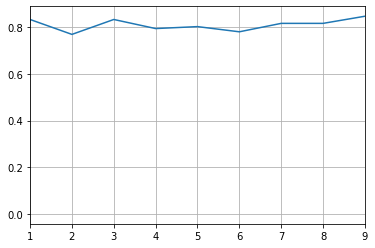

In [10]:
compute_linear_results(X_train, X_test) # all dimensions

## 10. Calcul du taux de réussite en classement d'un réseau linéaire multicouches sur les données réduites
Cette deuxième étape consiste à avoir les résultats sur les dimensions réduites engendrées par la réduction de dimensionnalité.

Je vais utiliser 1 layers
 [-] epoch    1/250, train loss 0.691972 in 0.03s
 [-] epoch    2/250, train loss 0.685599 in 0.02s
 [-] epoch    3/250, train loss 0.683649 in 0.02s
 [-] epoch    4/250, train loss 0.675693 in 0.02s
 [-] epoch    5/250, train loss 0.676556 in 0.02s
 [-] epoch    6/250, train loss 0.672031 in 0.02s
 [-] epoch    7/250, train loss 0.674704 in 0.03s
 [-] epoch    8/250, train loss 0.671867 in 0.02s
 [-] epoch    9/250, train loss 0.678673 in 0.03s
 [-] epoch   10/250, train loss 0.668243 in 0.03s
 [-] epoch   11/250, train loss 0.662384 in 0.02s
 [-] epoch   12/250, train loss 0.669996 in 0.02s
 [-] epoch   13/250, train loss 0.666203 in 0.02s
 [-] epoch   14/250, train loss 0.663590 in 0.03s
 [-] epoch   15/250, train loss 0.661044 in 0.02s
 [-] epoch   16/250, train loss 0.657437 in 0.02s
 [-] epoch   17/250, train loss 0.661507 in 0.03s
 [-] epoch   18/250, train loss 0.655352 in 0.03s
 [-] epoch   19/250, train loss 0.653724 in 0.02s
 [-] epoch   20/250, tra

 [-] epoch  164/250, train loss 0.603694 in 0.02s
 [-] epoch  165/250, train loss 0.609142 in 0.02s
 [-] epoch  166/250, train loss 0.605283 in 0.03s
 [-] epoch  167/250, train loss 0.609704 in 0.02s
 [-] epoch  168/250, train loss 0.608780 in 0.03s
 [-] epoch  169/250, train loss 0.605533 in 0.03s
 [-] epoch  170/250, train loss 0.601683 in 0.02s
 [-] epoch  171/250, train loss 0.597413 in 0.03s
 [-] epoch  172/250, train loss 0.609986 in 0.02s
 [-] epoch  173/250, train loss 0.616073 in 0.03s
 [-] epoch  174/250, train loss 0.613796 in 0.02s
 [-] epoch  175/250, train loss 0.614703 in 0.03s
 [-] epoch  176/250, train loss 0.614616 in 0.03s
 [-] epoch  177/250, train loss 0.614378 in 0.03s
 [-] epoch  178/250, train loss 0.613399 in 0.03s
 [-] epoch  179/250, train loss 0.601262 in 0.02s
 [-] epoch  180/250, train loss 0.615019 in 0.03s
 [-] epoch  181/250, train loss 0.598610 in 0.03s
 [-] epoch  182/250, train loss 0.599386 in 0.03s
 [-] epoch  183/250, train loss 0.609544 in 0.02s


 [-] epoch   76/250, train loss 0.535586 in 0.08s
 [-] epoch   77/250, train loss 0.517205 in 0.06s
 [-] epoch   78/250, train loss 0.537457 in 0.06s
 [-] epoch   79/250, train loss 0.511105 in 0.06s
 [-] epoch   80/250, train loss 0.534680 in 0.08s
 [-] epoch   81/250, train loss 0.527200 in 0.07s
 [-] epoch   82/250, train loss 0.499212 in 0.07s
 [-] epoch   83/250, train loss 0.525313 in 0.07s
 [-] epoch   84/250, train loss 0.520197 in 0.09s
 [-] epoch   85/250, train loss 0.487799 in 0.07s
 [-] epoch   86/250, train loss 0.512964 in 0.07s
 [-] epoch   87/250, train loss 0.474990 in 0.07s
 [-] epoch   88/250, train loss 0.507938 in 0.07s
 [-] epoch   89/250, train loss 0.534446 in 0.06s
 [-] epoch   90/250, train loss 0.503080 in 0.09s
 [-] epoch   91/250, train loss 0.529373 in 0.07s
 [-] epoch   92/250, train loss 0.490581 in 0.10s
 [-] epoch   93/250, train loss 0.499377 in 0.08s
 [-] epoch   94/250, train loss 0.482773 in 0.06s
 [-] epoch   95/250, train loss 0.521411 in 0.07s


 [-] epoch  239/250, train loss 0.451195 in 0.08s
 [-] epoch  240/250, train loss 0.481513 in 0.06s
 [-] epoch  241/250, train loss 0.474872 in 0.06s
 [-] epoch  242/250, train loss 0.458786 in 0.06s
 [-] epoch  243/250, train loss 0.457489 in 0.06s
 [-] epoch  244/250, train loss 0.460950 in 0.07s
 [-] epoch  245/250, train loss 0.487538 in 0.07s
 [-] epoch  246/250, train loss 0.470728 in 0.06s
 [-] epoch  247/250, train loss 0.446211 in 0.06s
 [-] epoch  248/250, train loss 0.431529 in 0.07s
 [-] epoch  249/250, train loss 0.463077 in 0.07s
 [-] epoch  250/250, train loss 0.461071 in 0.07s
 [-] test acc. 60.277778%
Je vais utiliser 3 layers
 [-] epoch    1/250, train loss 0.666993 in 0.09s
 [-] epoch    2/250, train loss 0.634877 in 0.09s
 [-] epoch    3/250, train loss 0.615360 in 0.09s
 [-] epoch    4/250, train loss 0.579957 in 0.10s
 [-] epoch    5/250, train loss 0.581414 in 0.11s
 [-] epoch    6/250, train loss 0.576385 in 0.13s
 [-] epoch    7/250, train loss 0.549974 in 0.13

 [-] epoch  151/250, train loss 0.407647 in 0.11s
 [-] epoch  152/250, train loss 0.420191 in 0.10s
 [-] epoch  153/250, train loss 0.429501 in 0.10s
 [-] epoch  154/250, train loss 0.400269 in 0.11s
 [-] epoch  155/250, train loss 0.431194 in 0.15s
 [-] epoch  156/250, train loss 0.424530 in 0.15s
 [-] epoch  157/250, train loss 0.414018 in 0.13s
 [-] epoch  158/250, train loss 0.398419 in 0.15s
 [-] epoch  159/250, train loss 0.429969 in 0.13s
 [-] epoch  160/250, train loss 0.418781 in 0.15s
 [-] epoch  161/250, train loss 0.422375 in 0.14s
 [-] epoch  162/250, train loss 0.418943 in 0.13s
 [-] epoch  163/250, train loss 0.418474 in 0.15s
 [-] epoch  164/250, train loss 0.409737 in 0.13s
 [-] epoch  165/250, train loss 0.416724 in 0.14s
 [-] epoch  166/250, train loss 0.426375 in 0.14s
 [-] epoch  167/250, train loss 0.413167 in 0.13s
 [-] epoch  168/250, train loss 0.413011 in 0.10s
 [-] epoch  169/250, train loss 0.416265 in 0.11s
 [-] epoch  170/250, train loss 0.402829 in 0.10s


 [-] epoch   63/250, train loss 0.467840 in 0.17s
 [-] epoch   64/250, train loss 0.459045 in 0.17s
 [-] epoch   65/250, train loss 0.429501 in 0.20s
 [-] epoch   66/250, train loss 0.450277 in 0.13s
 [-] epoch   67/250, train loss 0.432724 in 0.15s
 [-] epoch   68/250, train loss 0.440041 in 0.19s
 [-] epoch   69/250, train loss 0.444753 in 0.21s
 [-] epoch   70/250, train loss 0.471999 in 0.18s
 [-] epoch   71/250, train loss 0.415073 in 0.17s
 [-] epoch   72/250, train loss 0.437519 in 0.18s
 [-] epoch   73/250, train loss 0.449583 in 0.20s
 [-] epoch   74/250, train loss 0.453583 in 0.14s
 [-] epoch   75/250, train loss 0.443709 in 0.12s
 [-] epoch   76/250, train loss 0.457237 in 0.15s
 [-] epoch   77/250, train loss 0.443818 in 0.21s
 [-] epoch   78/250, train loss 0.434927 in 0.19s
 [-] epoch   79/250, train loss 0.420145 in 0.19s
 [-] epoch   80/250, train loss 0.438665 in 0.18s
 [-] epoch   81/250, train loss 0.413711 in 0.21s
 [-] epoch   82/250, train loss 0.436282 in 0.20s


 [-] epoch  226/250, train loss 0.365634 in 0.15s
 [-] epoch  227/250, train loss 0.355450 in 0.14s
 [-] epoch  228/250, train loss 0.352913 in 0.18s
 [-] epoch  229/250, train loss 0.425764 in 0.16s
 [-] epoch  230/250, train loss 0.396907 in 0.16s
 [-] epoch  231/250, train loss 0.388374 in 0.17s
 [-] epoch  232/250, train loss 0.368411 in 0.16s
 [-] epoch  233/250, train loss 0.363625 in 0.19s
 [-] epoch  234/250, train loss 0.361337 in 0.17s
 [-] epoch  235/250, train loss 0.360227 in 0.18s
 [-] epoch  236/250, train loss 0.397721 in 0.20s
 [-] epoch  237/250, train loss 0.360581 in 0.18s
 [-] epoch  238/250, train loss 0.376360 in 0.17s
 [-] epoch  239/250, train loss 0.418550 in 0.19s
 [-] epoch  240/250, train loss 0.432566 in 0.17s
 [-] epoch  241/250, train loss 0.391511 in 0.17s
 [-] epoch  242/250, train loss 0.352999 in 0.16s
 [-] epoch  243/250, train loss 0.357486 in 0.14s
 [-] epoch  244/250, train loss 0.357659 in 0.15s
 [-] epoch  245/250, train loss 0.384603 in 0.15s


 [-] epoch  138/250, train loss 0.394818 in 0.18s
 [-] epoch  139/250, train loss 0.390120 in 0.21s
 [-] epoch  140/250, train loss 0.391070 in 0.22s
 [-] epoch  141/250, train loss 0.392149 in 0.20s
 [-] epoch  142/250, train loss 0.385804 in 0.20s
 [-] epoch  143/250, train loss 0.393566 in 0.21s
 [-] epoch  144/250, train loss 0.373374 in 0.21s
 [-] epoch  145/250, train loss 0.387160 in 0.22s
 [-] epoch  146/250, train loss 0.360725 in 0.19s
 [-] epoch  147/250, train loss 0.404219 in 0.18s
 [-] epoch  148/250, train loss 0.374826 in 0.18s
 [-] epoch  149/250, train loss 0.403130 in 0.20s
 [-] epoch  150/250, train loss 0.389652 in 0.21s
 [-] epoch  151/250, train loss 0.390774 in 0.22s
 [-] epoch  152/250, train loss 0.416269 in 0.20s
 [-] epoch  153/250, train loss 0.346315 in 0.23s
 [-] epoch  154/250, train loss 0.390886 in 0.20s
 [-] epoch  155/250, train loss 0.367882 in 0.20s
 [-] epoch  156/250, train loss 0.380248 in 0.21s
 [-] epoch  157/250, train loss 0.349017 in 0.21s


 [-] epoch   50/250, train loss 0.468548 in 0.23s
 [-] epoch   51/250, train loss 0.440009 in 0.23s
 [-] epoch   52/250, train loss 0.443316 in 0.28s
 [-] epoch   53/250, train loss 0.440384 in 0.25s
 [-] epoch   54/250, train loss 0.463673 in 0.28s
 [-] epoch   55/250, train loss 0.421267 in 0.23s
 [-] epoch   56/250, train loss 0.426798 in 0.22s
 [-] epoch   57/250, train loss 0.425959 in 0.17s
 [-] epoch   58/250, train loss 0.432984 in 0.27s
 [-] epoch   59/250, train loss 0.439727 in 0.20s
 [-] epoch   60/250, train loss 0.431466 in 0.16s
 [-] epoch   61/250, train loss 0.423297 in 0.24s
 [-] epoch   62/250, train loss 0.423885 in 0.25s
 [-] epoch   63/250, train loss 0.424517 in 0.25s
 [-] epoch   64/250, train loss 0.430963 in 0.25s
 [-] epoch   65/250, train loss 0.425117 in 0.27s
 [-] epoch   66/250, train loss 0.428619 in 0.25s
 [-] epoch   67/250, train loss 0.430554 in 0.19s
 [-] epoch   68/250, train loss 0.392684 in 0.17s
 [-] epoch   69/250, train loss 0.408760 in 0.24s


 [-] epoch  213/250, train loss 0.333944 in 0.19s
 [-] epoch  214/250, train loss 0.311539 in 0.17s
 [-] epoch  215/250, train loss 0.295808 in 0.16s
 [-] epoch  216/250, train loss 0.297011 in 0.19s
 [-] epoch  217/250, train loss 0.328455 in 0.17s
 [-] epoch  218/250, train loss 0.311645 in 0.17s
 [-] epoch  219/250, train loss 0.327740 in 0.16s
 [-] epoch  220/250, train loss 0.336486 in 0.16s
 [-] epoch  221/250, train loss 0.332637 in 0.16s
 [-] epoch  222/250, train loss 0.347580 in 0.18s
 [-] epoch  223/250, train loss 0.339018 in 0.17s
 [-] epoch  224/250, train loss 0.314536 in 0.18s
 [-] epoch  225/250, train loss 0.305386 in 0.18s
 [-] epoch  226/250, train loss 0.344919 in 0.16s
 [-] epoch  227/250, train loss 0.342442 in 0.16s
 [-] epoch  228/250, train loss 0.323554 in 0.16s
 [-] epoch  229/250, train loss 0.332426 in 0.17s
 [-] epoch  230/250, train loss 0.313232 in 0.17s
 [-] epoch  231/250, train loss 0.324277 in 0.19s
 [-] epoch  232/250, train loss 0.327631 in 0.26s


 [-] epoch  125/250, train loss 0.377211 in 0.19s
 [-] epoch  126/250, train loss 0.385229 in 0.24s
 [-] epoch  127/250, train loss 0.398271 in 0.25s
 [-] epoch  128/250, train loss 0.367977 in 0.20s
 [-] epoch  129/250, train loss 0.366809 in 0.21s
 [-] epoch  130/250, train loss 0.407094 in 0.21s
 [-] epoch  131/250, train loss 0.407874 in 0.19s
 [-] epoch  132/250, train loss 0.369942 in 0.28s
 [-] epoch  133/250, train loss 0.364296 in 0.33s
 [-] epoch  134/250, train loss 0.370750 in 0.25s
 [-] epoch  135/250, train loss 0.355591 in 0.20s
 [-] epoch  136/250, train loss 0.366769 in 0.32s
 [-] epoch  137/250, train loss 0.362791 in 0.20s
 [-] epoch  138/250, train loss 0.403163 in 0.27s
 [-] epoch  139/250, train loss 0.385920 in 0.26s
 [-] epoch  140/250, train loss 0.367179 in 0.20s
 [-] epoch  141/250, train loss 0.369334 in 0.31s
 [-] epoch  142/250, train loss 0.351830 in 0.34s
 [-] epoch  143/250, train loss 0.366474 in 0.22s
 [-] epoch  144/250, train loss 0.348171 in 0.25s


 [-] epoch   37/250, train loss 0.477165 in 0.27s
 [-] epoch   38/250, train loss 0.453403 in 0.26s
 [-] epoch   39/250, train loss 0.465691 in 0.27s
 [-] epoch   40/250, train loss 0.429977 in 0.29s
 [-] epoch   41/250, train loss 0.458675 in 0.28s
 [-] epoch   42/250, train loss 0.449794 in 0.28s
 [-] epoch   43/250, train loss 0.449861 in 0.29s
 [-] epoch   44/250, train loss 0.445850 in 0.28s
 [-] epoch   45/250, train loss 0.420164 in 0.29s
 [-] epoch   46/250, train loss 0.400244 in 0.27s
 [-] epoch   47/250, train loss 0.451193 in 0.28s
 [-] epoch   48/250, train loss 0.451886 in 0.29s
 [-] epoch   49/250, train loss 0.422620 in 0.27s
 [-] epoch   50/250, train loss 0.446718 in 0.25s
 [-] epoch   51/250, train loss 0.439221 in 0.32s
 [-] epoch   52/250, train loss 0.447714 in 0.26s
 [-] epoch   53/250, train loss 0.412198 in 0.26s
 [-] epoch   54/250, train loss 0.394942 in 0.29s
 [-] epoch   55/250, train loss 0.424477 in 0.29s
 [-] epoch   56/250, train loss 0.435745 in 0.22s


 [-] epoch  200/250, train loss 0.337424 in 0.28s
 [-] epoch  201/250, train loss 0.373366 in 0.35s
 [-] epoch  202/250, train loss 0.346265 in 0.27s
 [-] epoch  203/250, train loss 0.313903 in 0.31s
 [-] epoch  204/250, train loss 0.344012 in 0.35s
 [-] epoch  205/250, train loss 0.367528 in 0.23s
 [-] epoch  206/250, train loss 0.334196 in 0.23s
 [-] epoch  207/250, train loss 0.315525 in 0.22s
 [-] epoch  208/250, train loss 0.319748 in 0.22s
 [-] epoch  209/250, train loss 0.356747 in 0.23s
 [-] epoch  210/250, train loss 0.365810 in 0.22s
 [-] epoch  211/250, train loss 0.353806 in 0.23s
 [-] epoch  212/250, train loss 0.359456 in 0.23s
 [-] epoch  213/250, train loss 0.350350 in 0.23s
 [-] epoch  214/250, train loss 0.344139 in 0.23s
 [-] epoch  215/250, train loss 0.352363 in 0.25s
 [-] epoch  216/250, train loss 0.331172 in 0.32s
 [-] epoch  217/250, train loss 0.330197 in 0.22s
 [-] epoch  218/250, train loss 0.313697 in 0.25s
 [-] epoch  219/250, train loss 0.348597 in 0.37s


 [-] epoch  112/250, train loss 0.389339 in 0.37s
 [-] epoch  113/250, train loss 0.391114 in 0.40s
 [-] epoch  114/250, train loss 0.376023 in 0.40s
 [-] epoch  115/250, train loss 0.366628 in 0.36s
 [-] epoch  116/250, train loss 0.400709 in 0.39s
 [-] epoch  117/250, train loss 0.383913 in 0.40s
 [-] epoch  118/250, train loss 0.374116 in 0.41s
 [-] epoch  119/250, train loss 0.360409 in 0.37s
 [-] epoch  120/250, train loss 0.394139 in 0.39s
 [-] epoch  121/250, train loss 0.372041 in 0.43s
 [-] epoch  122/250, train loss 0.366583 in 0.39s
 [-] epoch  123/250, train loss 0.371858 in 0.39s
 [-] epoch  124/250, train loss 0.372022 in 0.39s
 [-] epoch  125/250, train loss 0.381439 in 0.36s
 [-] epoch  126/250, train loss 0.356833 in 0.41s
 [-] epoch  127/250, train loss 0.376921 in 0.42s
 [-] epoch  128/250, train loss 0.365302 in 0.43s
 [-] epoch  129/250, train loss 0.371884 in 0.35s
 [-] epoch  130/250, train loss 0.356346 in 0.37s
 [-] epoch  131/250, train loss 0.371279 in 0.39s


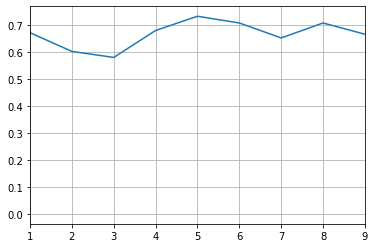

In [12]:
compute_linear_results(X_train_reduced, X_test_reduced)

## 11. Expérimentations - Déclaration d'un réseau de neurones de type convolution
Cette partie agit à titre d'expérimentation.

Le réseau de neurones à convolution est facile à paramétrer: il est possible d'y indiquer, en paramètre d'entrée, le nombre de filtres de convolution à rajouter à l'implémentation de base (pour augmenter la complexité du réseau à notre guise).

In [15]:
class RAMQNetConvolution(nn.Module):
    """
    Cette classe définit un réseau par convolution permettant de classifier des données de la RAMQ
    """

    def __init__(self, numberOfFilters):
        super().__init__()
        
        self.numberOfFilters = numberOfFilters
        
        self.C1 = nn.Conv1d(1, 32, kernel_size=251, stride=2, padding=125, bias=False)
        self.B1 = nn.BatchNorm1d(32)
        self.C2 = nn.Conv1d(32, 64, kernel_size=175, stride=2, padding=87, bias=False)
        
        self.B = nn.BatchNorm1d(64)
        
        self.C = nn.Conv1d(64, 64, kernel_size=175, stride=2, padding=87, bias=False)
        
        self.activation = nn.ELU()
        self.F1 = nn.Linear(64, 1)
        self.output = nn.Sigmoid()
        
    def forward(self, x):
        # Sélectionne la taille batch à l'entrée
        batch_size = x.shape[0]

        x = self.activation(self.B1(self.C1(x)))
        x = self.activation(self.B(self.C2(x)))
        
        for i in range(self.numberOfFilters):
            x = self.activation(self.B(self.C(x)))
        
        # Fait un average pooling sur les caractéristiques
        # de chaque filtre
        x = x.view(batch_size, 64, -1).mean(dim=2)
        
        # Couche lineaire et sigmoide
        x = self.F1(x)
        x = self.output(x)
        
        return x

## 12. Déclaration de la fonction permettant la classification par réseau de neurones profond de type convolution
Cette méthode n'a besoin, en entrées, que des jeux d'entraînement et de test normalisé, dont la dernière dimension de chaque donnée constitue la valeur de l'étiquette reliée. 

In [18]:
def compute_accuracy_for_convolution(model, dataloader, device='cpu'):
    training_before = model.training
    model.eval()
    all_predictions = []
    all_targets = []
    
    for i_batch, batch in enumerate(dataloader):
        values, targets = batch
        values = values.unsqueeze(1)
        values = values.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(values)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    if all_predictions[0].shape[-1] > 1:
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else:
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0
        predictions_numpy[predictions_numpy < 0.5] = 0.0

    if training_before:
        model.train()

    return (predictions_numpy == targets_numpy).mean()

def compute_convolution_results(X_train, X_test):
    # Définit si cuda est utilisé ou non
    # mettre cuda pour utiliser un GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Définit les paramètres d'entraînement 
    nb_epoch = 10
    learning_rate = 0.01
    momentum = 0.9
    batch_size = 32

    # Charge les données d'entraînement et de test
    train_set = RAMQDataset(X_train)
    test_set = RAMQDataset(X_test)

    # Crée le sampler avec les classes balancées
    balanced_train_sampler = create_balanced_sampler(train_set)
    balanced_test_sampler = create_balanced_sampler(test_set)

    # Crée le dataloader d'entraînement
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=balanced_train_sampler)
    test_loader = DataLoader(test_set, batch_size=batch_size, sampler=balanced_test_sampler)
    
    test_accu = []
    test_accu.append(0)
#     test_accu.append(0)
#     test_accu.append(0)
#     test_accu.append(0)
#     test_accu.append(0)
#     test_accu.append(0)
    
    for i in range(1, 11):
        print("Je vais ajouter " + str(i) + " filters")
        
        # Instancier un réseau RAMQNetConvolution
        # dans une variable nommée "model"
        model = RAMQNetConvolution(i)
        model.to(device)

        criterion = nn.BCELoss()

        # Instancier l'algorithme d'optimisation SGD
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

        # Mettre le réseau en mode entraînement
        model.train()

        for i_epoch in range(nb_epoch):

            start_time, train_losses = time.time(), []
            for i_batch, batch in enumerate(train_loader):
                values, targets = batch

                values = values.unsqueeze(1)
                targets = targets.type(torch.FloatTensor).unsqueeze(-1)

                values = values.to(device)
                targets = targets.to(device)

                # Mettre les gradients à zéro
                optimizer.zero_grad()

                # Calculer:
                # 1. l'inférence dans une variable "predictions"
                # 2. l'erreur dans une variable "loss"
                predictions = model(values)
                loss = criterion(predictions, targets)

                # Rétropropager l'erreur et effectuer une étape d'optimisation
                loss.backward()
                optimizer.step()

                # Ajoute le loss de la batch
                train_losses.append(loss.item())

            print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
            i_epoch+1, nb_epoch, numpy.mean(train_losses), time.time()-start_time))

        # affiche le score à l'écran
        test_acc = compute_accuracy_for_convolution(model, test_loader, device)
        print(' [-] test acc. {:.6f}%'.format(test_acc * 100))
        test_accu.append(test_acc)
    plot_results(test_accu, 1, 10)

## 13. Calcul du taux de réussite en classement d'un réseau de convolution sur les données non réduites - référence

Je vais ajouter 1 filters
 [-] epoch    1/10, train loss 0.649880 in 2.48s
 [-] epoch    2/10, train loss 0.541793 in 2.43s
 [-] epoch    3/10, train loss 0.460036 in 2.44s
 [-] epoch    4/10, train loss 0.356663 in 2.50s
 [-] epoch    5/10, train loss 0.315211 in 2.56s
 [-] epoch    6/10, train loss 0.319489 in 2.54s
 [-] epoch    7/10, train loss 0.334724 in 2.54s
 [-] epoch    8/10, train loss 0.289350 in 2.54s
 [-] epoch    9/10, train loss 0.303419 in 2.57s
 [-] epoch   10/10, train loss 0.249432 in 2.57s
 [-] test acc. 55.000000%
Je vais ajouter 2 filters
 [-] epoch    1/10, train loss 0.603194 in 3.13s
 [-] epoch    2/10, train loss 0.455592 in 3.13s
 [-] epoch    3/10, train loss 0.393886 in 3.11s
 [-] epoch    4/10, train loss 0.328554 in 3.11s
 [-] epoch    5/10, train loss 0.343695 in 3.10s
 [-] epoch    6/10, train loss 0.291574 in 3.11s
 [-] epoch    7/10, train loss 0.278741 in 3.11s
 [-] epoch    8/10, train loss 0.288595 in 3.11s
 [-] epoch    9/10, train loss 0.272868 

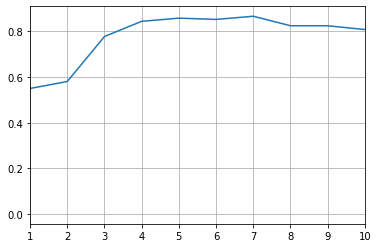

In [19]:
compute_convolution_results(X_train, X_test)

## 14. Calcul du taux de réussite en classement d'un réseau de convolution sur les données réduites

Je vais ajouter 1 filters
 [-] epoch    1/10, train loss 0.661160 in 0.70s
 [-] epoch    2/10, train loss 0.625633 in 0.70s
 [-] epoch    3/10, train loss 0.567836 in 0.59s
 [-] epoch    4/10, train loss 0.570159 in 0.59s
 [-] epoch    5/10, train loss 0.548566 in 0.60s
 [-] epoch    6/10, train loss 0.544793 in 0.59s
 [-] epoch    7/10, train loss 0.537454 in 0.77s
 [-] epoch    8/10, train loss 0.537653 in 0.75s
 [-] epoch    9/10, train loss 0.526692 in 0.67s
 [-] epoch   10/10, train loss 0.511782 in 0.66s
 [-] test acc. 67.500000%
Je vais ajouter 2 filters
 [-] epoch    1/10, train loss 0.662841 in 1.00s
 [-] epoch    2/10, train loss 0.658505 in 0.99s
 [-] epoch    3/10, train loss 0.602539 in 0.99s
 [-] epoch    4/10, train loss 0.614907 in 1.00s
 [-] epoch    5/10, train loss 0.555207 in 0.98s
 [-] epoch    6/10, train loss 0.590134 in 0.99s
 [-] epoch    7/10, train loss 0.555016 in 0.99s
 [-] epoch    8/10, train loss 0.545348 in 0.99s
 [-] epoch    9/10, train loss 0.533741 

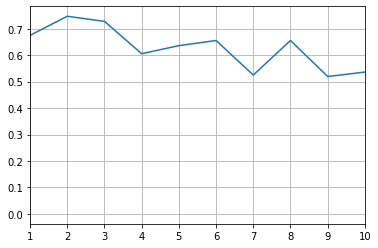

In [20]:
compute_convolution_results(X_train_reduced, X_test_reduced)